# 04c - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)


### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Create Dataset
- Train Forecasting Model with AutoML
    - Create AutoML Forecasting Job
    - Run AutoML Forecasting Job
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Vertex AI API)](https://cloud.google.com/vertex-ai/docs/training/automl-api#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04c_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04c_console.png">

---
## Setup

inputs:

In [1]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04c'

packages:

In [2]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [3]:
bigquery = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

---
## Create Dataset (Link to BigQuery Table)

Reference for [`aiplatform.TimeSeriesDataset.create`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.TimeSeriesDataset.create)

In [5]:
dataset = aiplatform.TimeSeriesDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TimeSeriesDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TimeSeriesDataset backing LRO: projects/715288179162/locations/us-central1/datasets/4283121157722341376/operations/7876879929629999104
INFO:google.cloud.aiplatform.datasets.dataset:TimeSeriesDataset created. Resource name: projects/715288179162/locations/us-central1/datasets/4283121157722341376
INFO:google.cloud.aiplatform.datasets.dataset:To use this TimeSeriesDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/4283121157722341376')


In [6]:
#dataset = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/4283121157722341376')

---
## Train Forecasting Model with AutoML

### Create AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob)

In [7]:
dataset.column_names

['splits', 'num_trips', 'date', 'start_station_name']

In [8]:
column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'num_trips': 'auto', 'date': 'auto'}

In [9]:
forecast_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    optimization_objective = "minimize-rmse",
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

### Run AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob.run`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob.run)

In [11]:
forecast = forecast_job.run(
    dataset = dataset,
    target_column = "num_trips",
    time_column = "date",
    time_series_identifier_column = "start_station_name",
    unavailable_at_forecast_columns = ["num_trips",],
    available_at_forecast_columns = ["date",],
    forecast_horizon = 16,
    data_granularity_unit = "day",
    data_granularity_count = 1,
    predefined_split_column_name = "splits",
    context_window = 32,
    export_evaluated_data_items = True,
    export_evaluated_data_items_bigquery_destination_uri = f"bq://{PROJECT_ID}:{DATANAME}:{NOTEBOOK}_automl",
    validation_options = "fail-pipeline",
    budget_milli_node_hours = 1000,
    model_display_name = f"{NOTEBOOK}_{DATANAME}_{TIMESTAMP}",
    model_labels = {'notebook':f'{NOTEBOOK}'},
    sync = False
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5508395475239174144?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/5508395475239174144 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/5508395475239174144 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/5508395475239174144 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/5508395475239174144 current state:
PipelineState.PIPELINE_STATE_RUNNING
I

---
## Results

### Retrieve Test Data

In [12]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predited_on_date,num_trips,splits,predicted_num_trips
0,Central Park S & 6 Ave,2016-09-15,0,2016-09-15,392,TEST,299.864014
1,Central Park W & W 96 St,2016-09-15,0,2016-09-15,75,TEST,98.643242
2,Central Park West & W 68 St,2016-09-15,0,2016-09-15,170,TEST,153.271591
3,Central Park West & W 72 St,2016-09-15,0,2016-09-15,180,TEST,183.690781
4,Central Park West & W 76 St,2016-09-15,0,2016-09-15,101,TEST,104.341629
...,...,...,...,...,...,...,...
178,Central Park West & W 100 St,2016-09-30,0,2016-09-30,13,TEST,41.677898
179,Central Park West & W 102 St,2016-09-30,0,2016-09-30,10,TEST,53.364857
180,W 106 St & Central Park West,2016-09-30,0,2016-09-30,32,TEST,67.894211
181,Grand Army Plaza & Central Park S,2016-09-30,0,2016-09-30,43,TEST,252.258896


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [17]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.660146,45.244315,0.291899
1,Central Park S & 6 Ave,forecast,0.542311,88.390194,0.266637
2,Central Park W & W 96 St,forecast,0.541462,23.069310,0.233761
3,Central Park West & W 100 St,forecast,0.891336,14.866694,0.360952
4,Central Park West & W 102 St,forecast,0.510201,12.810602,0.247249
5,Central Park West & W 68 St,forecast,0.464130,44.523619,0.291361
6,Central Park West & W 72 St,forecast,0.631317,54.914485,0.301728
7,Central Park West & W 76 St,forecast,0.329753,24.140621,0.216387
8,Central Park West & W 85 St,forecast,1.017384,51.317795,0.418352
9,Grand Army Plaza & Central Park S,forecast,0.578597,66.008325,0.294768


### Retrieve the Forecasting Data (raw series)

In [14]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [15]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


### Visualize The Time Series with Forecast

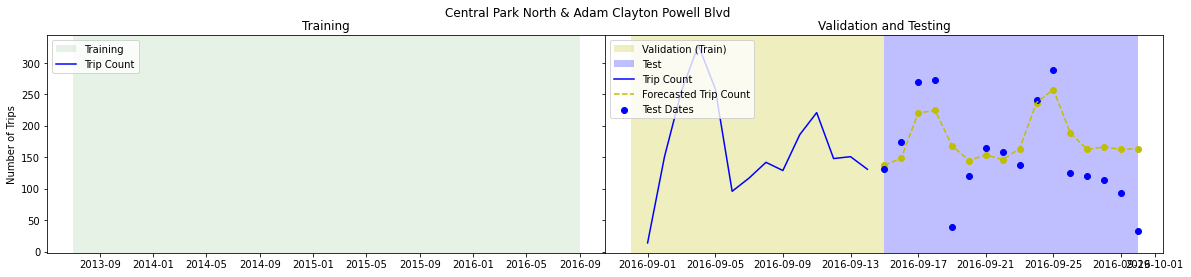

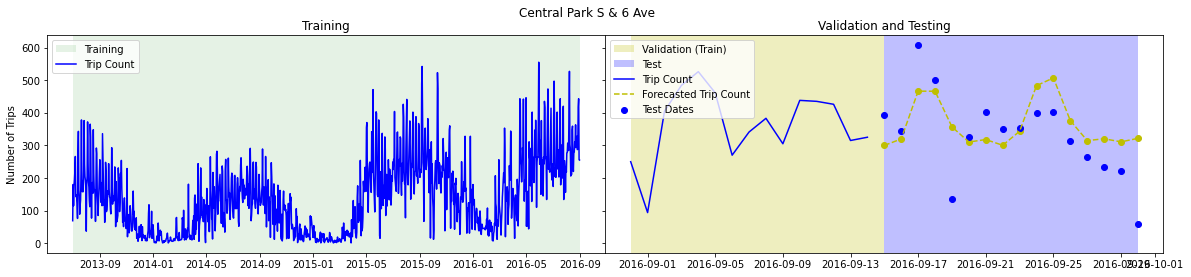

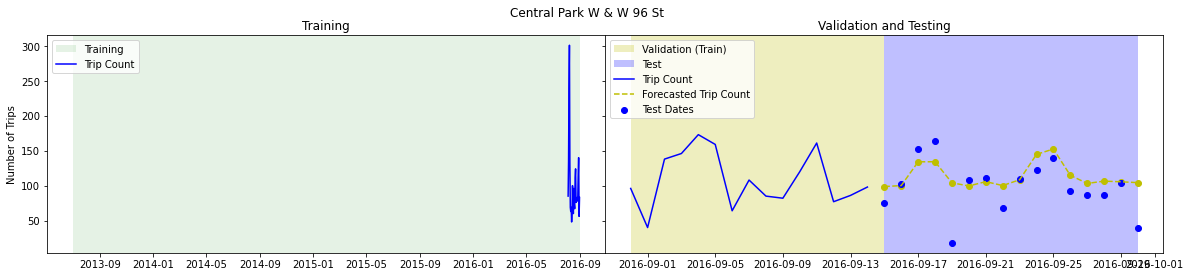

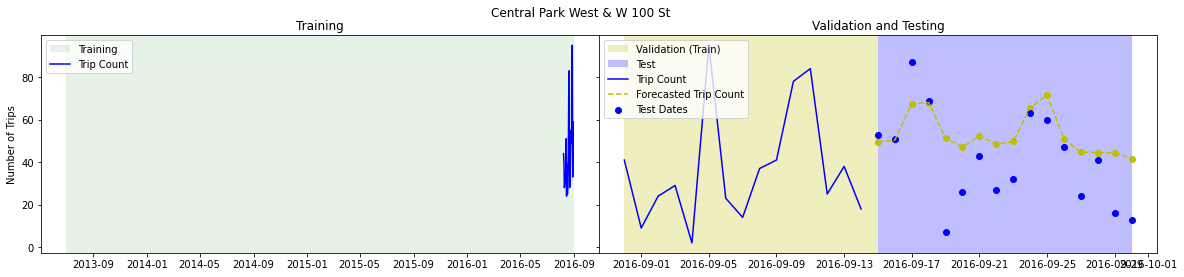

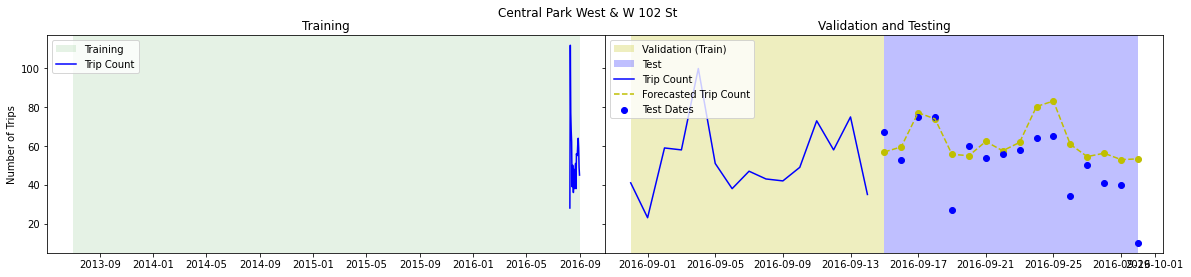

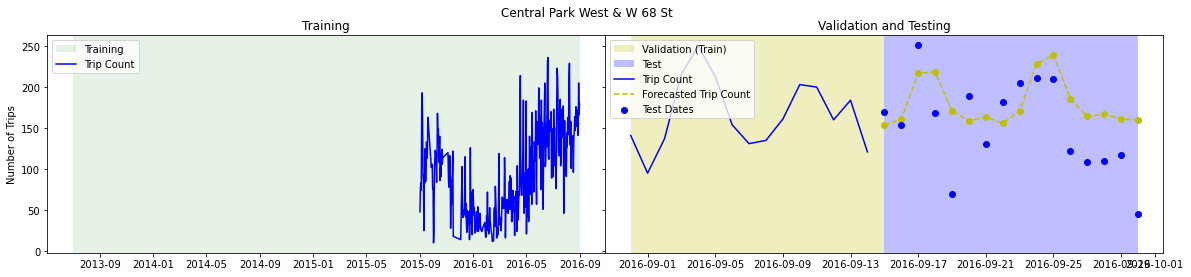

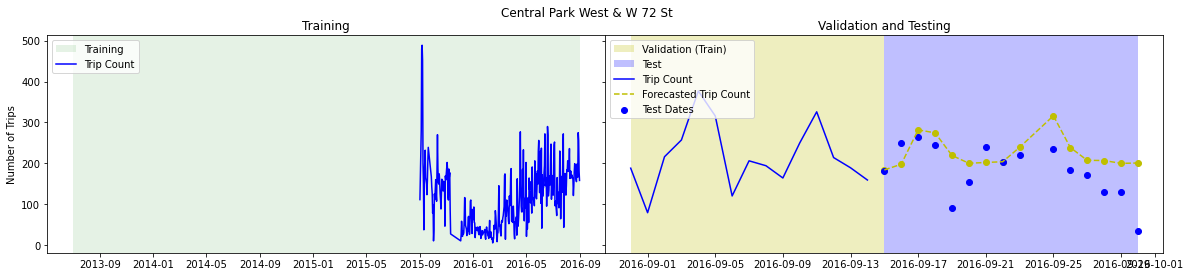

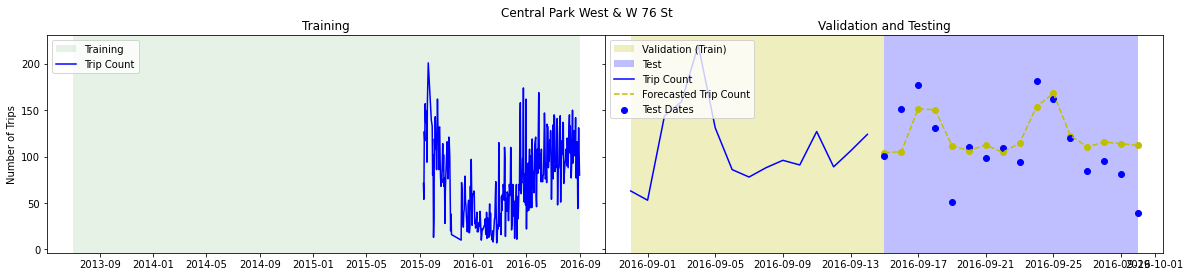

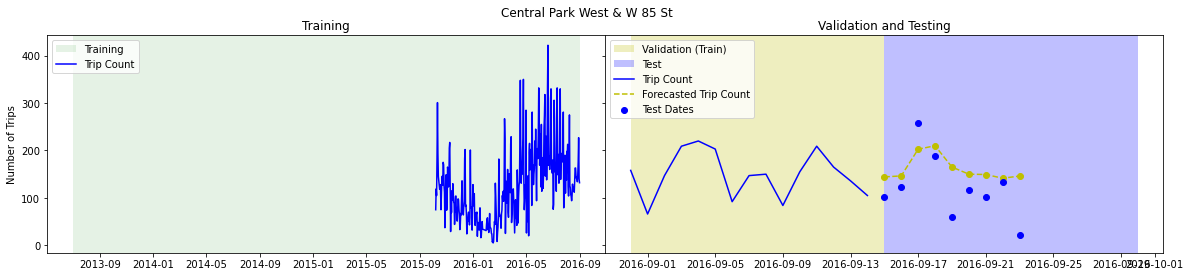

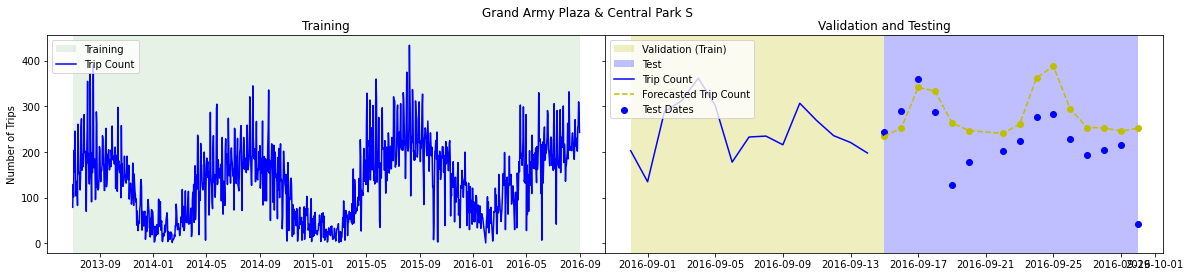

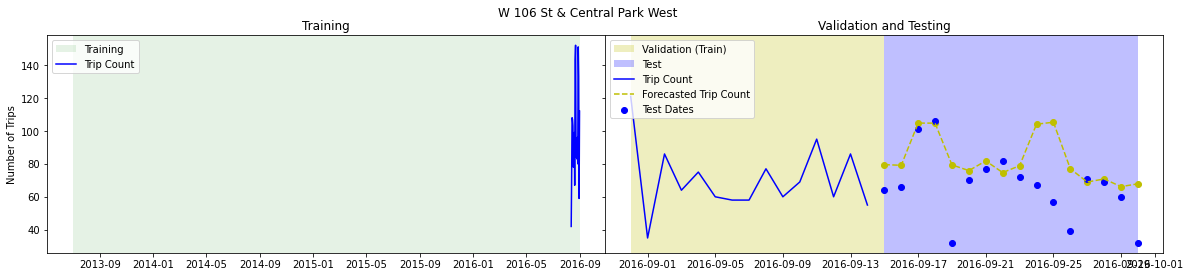

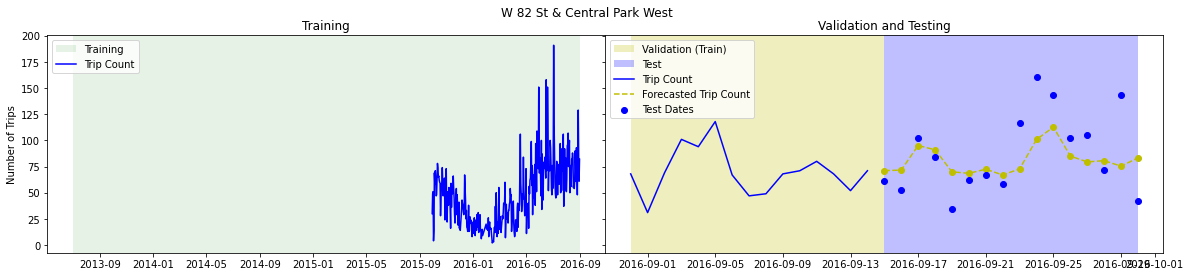

In [16]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"